# Homework 4: Conversation Modeling and decoding

In [0]:
import re
from collections import Counter
from tqdm import tqdm
import json
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from utils import ChatDictionary, ChatDataset, pad_tensor, argsort, batchify, _HypothesisTail, reorder_encoder_states, reorder_decoder_incremental_state, get_nbest_list_from_beam

# Part 1 Modeling

## 1.1 Attention visulization

In [0]:
### set up the model and complete the corresponding task

### the pretrained model was trained in ~2 hours, i.e. you can expect attention maps
### to look quite 'hard' (less soft spreading) i.e. attending to some particular token in the input

### You present here:

In [0]:
# this is some example attention map here, 
# *make sure you add text tokens on the axes to make it readable!*

![Imgur](https://i.imgur.com/xodciCU.png)

## 1.2 Encoder Transformer

In [0]:
RETOK = re.compile(r'\w+|[^\w\s]|\n', re.UNICODE)

In [5]:
import os

### persona chat dataset
if not os.path.exists('./dict'):
    !wget "https://nyu.box.com/shared/static/sj9f87tofpicll89xbc154pmbztu5q4h" -O './dict'
if not os.path.exists('./train.jsonl'):
    !wget "https://nyu.box.com/shared/static/aqp0jyjaixjmukm5asasivq2bcfze075.jsonl" -O './train.jsonl'
if not os.path.exists('./valid.jsonl'):
    !wget "https://nyu.box.com/shared/static/eg4ivddtqib2hkf1k8rkxnmzmo0cq27p.jsonl" -O './valid.jsonl'

if not os.path.exists('./chat_model_best_22.pt'):
    !wget "https://nyu.box.com/shared/static/24zsynuks8nzg7530tgakzh8o62id9xa.pt" -O './chat_model_best_22.pt'

chat_dict = ChatDictionary('./dict')
train_dataset = ChatDataset('./train.jsonl', chat_dict)
valid_dataset = ChatDataset('./valid.jsonl', chat_dict, 'valid')

--2019-11-12 14:29:52--  https://nyu.box.com/shared/static/sj9f87tofpicll89xbc154pmbztu5q4h
Resolving nyu.box.com (nyu.box.com)... 103.116.4.197
Connecting to nyu.box.com (nyu.box.com)|103.116.4.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/sj9f87tofpicll89xbc154pmbztu5q4h [following]
--2019-11-12 14:29:52--  https://nyu.box.com/public/static/sj9f87tofpicll89xbc154pmbztu5q4h
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/sj9f87tofpicll89xbc154pmbztu5q4h [following]
--2019-11-12 14:29:52--  https://nyu.app.box.com/public/static/sj9f87tofpicll89xbc154pmbztu5q4h
Resolving nyu.app.box.com (nyu.app.box.com)... 103.116.4.199
Connecting to nyu.app.box.com (nyu.app.box.com)|103.116.4.199|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/b1!2BLHLX93vRJ6lcfSqM9zz0

100%|██████████| 7801/7801 [00:00<00:00, 9384.08it/s]


In [0]:
train_loader = DataLoader(train_dataset, shuffle=True, collate_fn=batchify, batch_size=64)
valid_loader = DataLoader(valid_dataset, shuffle=False, collate_fn=batchify, batch_size=64)

In [0]:
### add transformer encoder as optional encoder in seq2seq model.

# code below can help you to start it, but feel free to start from scratch

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import numpy as np
class EncoderRNN(nn.Module):
    """Encodes the input context."""

    # def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx=0, dropout=0, shared_lt=None):
    #     super().__init__()
    #     self.vocab_size = vocab_size
    #     self.embed_size = embed_size
    #     self.hidden_size = hidden_size
    #     self.num_layers = num_layers
    #     self.dropout = nn.Dropout(p=dropout)
    #     self.pad_idx = pad_idx
        
    #     if shared_lt is None:
    #         self.embedding = nn.Embedding(self.vocab_size, self.embed_size, pad_idx)
    #     else:
    #         self.embedding = shared_lt
            
    #     self.gru = nn.GRU(
    #         self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
    #     )
        
        
    # def forward(self, text_vec, text_lens, hidden=None, use_packed=True):
    #     embedded = self.embedding(text_vec)
    #     attention_mask = text_vec.ne(self.pad_idx)

    #     embedded = self.dropout(embedded)
    #     if use_packed is True:
    #         embedded = pack_padded_sequence(embedded, text_lens, batch_first=True)
    #     output, hidden = self.gru(embedded, hidden)
    #     if use_packed is True:
    #         output, output_lens = pad_packed_sequence(output, batch_first=True)
        
    #     return output, hidden, attention_mask

    
    def __init__(self, vocab_size, embed_size, hidden_size, dropout, num_layers,shared_lt, max_len = 7500, nhead=4, pad_idx= 0):
        super(EncoderRNN, self).__init__()

        self.vocab_size = vocab_size
        self.max_len = max_len
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.nhead = nhead
        self.num_layers = num_layers
        self.pad_idx = pad_idx

        self.position_embed = nn.Embedding(num_embeddings = self.max_len, embedding_dim = self.embed_size)
        encoder_layer = nn.TransformerEncoderLayer(self.embed_size, self.nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, self.num_layers)
        self.token_embed = shared_lt
        self.dropout = nn.Dropout(p = self.dropout)

    def _generate_mask(self, sentence_len):
        "Mask out subsequent positions."
        attn_shape = (sentence_len, sentence_len)
        subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
        return torch.from_numpy(subsequent_mask) == 0

    def forward(self, text_vec, text_lens, hidden=None, use_packed=True): 
        # text_vec: batch x length 
        pos = torch.arange(text_vec.size(1), device = text_vec.device).expand(text_vec.size(0),-1).view(-1, text_vec.size(1))
        pos_embedded = self.position_embed(pos)
        tok_embedded = self.token_embed(text_vec)
        embedded = pos_embedded + tok_embedded  # apply pos embedding
        embedded = self.dropout(embedded)

        attention_mask_pos = self._generate_mask(text_vec.size(1))
        attention_mask_pad = text_vec.eq(self.pad_idx)
        
        output = self.transformer(embedded.transpose(0,1), 
                                  src_key_padding_mask=attention_mask_pad.to(text_vec.device),
                                  mask = attention_mask_pos.to(text_vec.device))
        output.transpose_(0,1)
        #print('output shape', output.size())
        hidden_encoder = torch.mean(output, dim = 1, keepdim=True).transpose(0,1).expand(2,-1,-1).contiguous() # 2 because decoder num_layers 
        #print('hidden layer shape', hidden_encoder.size())
        return output, hidden_encoder, attention_mask_pad
    

class DecoderRNN(nn.Module):
    """Generates a sequence of tokens in response to context."""

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout=0):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        
        self.embedding = nn.Embedding(self.vocab_size, self.embed_size, 0)
        
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
        
        self.attention = AttentionLayer(self.hidden_size, self.embed_size)

        self.out = nn.Linear(self.hidden_size, self.vocab_size)
        self.longest_label = 100

    def forward(self, text_vec, decoder_hidden, encoder_states):
        emb = self.embedding(text_vec)
        emb = self.dropout(emb)
        seqlen = text_vec.size(1)
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        decoder_hidden = decoder_hidden
        output = []
        attn_w_log = []

        for i in range(seqlen):
            decoder_output, decoder_hidden = self.gru(emb[:,i,:].unsqueeze(1), decoder_hidden)
            
            # compute attention at each time step
            decoder_output_attended, attn_weights = self.attention(decoder_output, decoder_hidden, encoder_output, attention_mask)
            output.append(decoder_output_attended)
            attn_w_log.append(attn_weights)
            
        output = torch.cat(output, dim=1).to(text_vec.device)
        scores = self.out(output)
        

        return scores, decoder_hidden, attn_w_log
    
    def decode_forced(self, ys, encoder_states, xs_lens):
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        batch_size = ys.size(0)
        target_length = ys.size(1)
        longest_label = max(target_length, self.longest_label)
        
        starts = torch.Tensor([1]).long().to(self.embedding.weight.device).expand(batch_size, 1).long()  # expand to batch size
        
        # Teacher forcing: Feed the target as the next input
        y_in = ys.narrow(1, 0, ys.size(1) - 1)
        decoder_input = torch.cat([starts, y_in], 1)
        decoder_output, decoder_hidden, attn_w_log = self.forward(decoder_input, encoder_hidden, encoder_states)
        _, preds = decoder_output.max(dim=2)
        
        return decoder_output, preds, attn_w_log
    
    
class AttentionLayer(nn.Module):

    def __init__(self, hidden_size, embedding_size):
        super().__init__()
        input_dim = hidden_size

        self.linear_out = nn.Linear(hidden_size+input_dim, input_dim, bias=False)
        self.softmax = nn.Softmax(dim=-1)
        self.tanh = nn.Tanh()

    def forward(self, decoder_output, decoder_hidden, encoder_output, attention_mask):

        batch_size, seq_length, hidden_size = encoder_output.size()

        encoder_output_t = encoder_output.transpose(1,2)
        
        attention_scores = torch.bmm(decoder_output, encoder_output_t).squeeze(1)

        attention_scores.masked_fill_((attention_mask), -10e5)
        attention_weights = self.softmax(attention_scores)

        mix = torch.bmm(attention_weights.unsqueeze(1), encoder_output)

        combined = torch.cat((decoder_output.squeeze(1), mix.squeeze(1)), dim=1)

        output = self.linear_out(combined).unsqueeze(1)
        output = self.tanh(output)

        return output, attention_weights
    
class seq2seq(nn.Module):
    """
    Generic seq2seq model with attention mechanism.
    """
    def __init__(self, opts):

        super().__init__()
        self.opts = opts
        
        self.decoder = DecoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_dec'],
                                    dropout=self.opts['dropout'],
                                )
        
        self.encoder = EncoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_enc'],
                                    dropout=self.opts['dropout'],
                                    shared_lt=self.decoder.embedding,
                                    # ### Transformer
                                    # max_len = self.opts['max_len'],
                                    # nhead = self.opts['nhead'],
    
        )
        
    def train(self):
        self.encoder.train()
        self.decoder.train()
        
    def eval(self):
        self.encoder.eval()
        self.decoder.eval()

In [0]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

load_pretrained = False
    
if load_pretrained is True:
    if current_device == 'cuda':
        model_pt = torch.load('./transformer_best_6.pt')
    else:
        model_pt = torch.load('./transformer_best_6.pt', map_location=torch.device('cpu'))
    opts = model_pt['opts']
    
    model = seq2seq(opts)
    model.load_state_dict(model_pt['state_dict'])
    model.to(current_device)
    
else:
    
    opts = {}

    opts['vocab_size'] = len(chat_dict)
    opts['hidden_size'] = 256
    opts['embedding_size'] = 256
    opts['num_layers_enc'] = 2
    opts['num_layers_dec'] = 2
    opts['dropout'] = 0.3
    opts['encoder_shared_lt'] = True
    
    ### Transformer 
    # opts['max_len'] = 7500
    # opts['nhead'] = 4
    
    
    model = seq2seq(opts)
    model.to(current_device)

In [0]:
criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='sum')
optimizer = torch.optim.AdamW(model.parameters(), 0.001, amsgrad=True, weight_decay = 0.01) # AdamW is Adam + weight decay
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

In [0]:
# check pdf to see what you expected to present

In [0]:
plot_cache = []

best_val_loss = 100

for epoch in range(15):
    
    model.train()
    sum_loss = 0
    sum_tokens = 0
    
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        
        text_vecs = batch['text_vecs'].to('cuda')
        target_vecs = batch['target_vecs'].to('cuda')
 
        encoded = model.encoder(text_vecs, batch['text_lens'], use_packed=batch['use_packed'])
        
        decoder_output, preds, attn_w_log = model.decoder.decode_forced(target_vecs, encoded, batch['text_lens'])
        
        scores = decoder_output.view(-1, decoder_output.size(-1))
        
        loss = criterion(scores, target_vecs.view(-1))
        sum_loss += loss.item()
        
        num_tokens = target_vecs.ne(0).long().sum().item()
        loss /= num_tokens
        
        sum_tokens += num_tokens
        
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            avg_train_loss = sum_loss/sum_tokens
            print("iter {} train loss = {}".format(i, sum_loss/sum_tokens))

    val_loss = 0
    val_tokens = 0
    for i, batch in enumerate(valid_loader):
        model.eval()
        
        text_vecs = batch['text_vecs'].to('cuda')
        target_vecs = batch['target_vecs'].to('cuda')
        
        encoded = model.encoder(text_vecs, batch['text_lens'], use_packed=batch['use_packed'])
        #encoded = model.encoder(text_vecs)
        
        decoder_output, preds, attn_w_log = model.decoder.decode_forced(target_vecs, encoded, batch['text_lens'])
        
        scores = decoder_output.view(-1, decoder_output.size(-1))
        
        loss = criterion(scores, target_vecs.view(-1))
        
        num_tokens = target_vecs.ne(0).long().sum().item()
        
        val_tokens += num_tokens
        val_loss += loss.item()
        
    avg_val_loss = val_loss/val_tokens
    val_perp = np.exp(avg_val_loss)
    scheduler.step(avg_val_loss)
        
    print("Epoch {} valid loss = {}".format(epoch, avg_val_loss))
    print("Epoch {} valid perp = {}".format(epoch, val_perp))
    
    plot_cache.append( (avg_train_loss, avg_val_loss) )
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        
        torch.save({
        'state_dict': model.state_dict(),
        'opts': opts,
        'plot_cache': plot_cache,
            }, f'./transformer_best_{epoch}.pt')

iter 0 train loss = 9.8188107823919
iter 100 train loss = 5.862565773542912


In [0]:
model_name = './transformer_best_0.pt'

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

if current_device == 'cuda':
    model_pt = torch.load(model_name)
else:
    model_pt = torch.load(model_name, map_location=torch.device('cpu'))
opts = model_pt['opts']

model = seq2seq(opts)
model.load_state_dict(model_pt['state_dict'])
model.to(current_device)

plot_cache = model_pt['plot_cache']

## You present here:

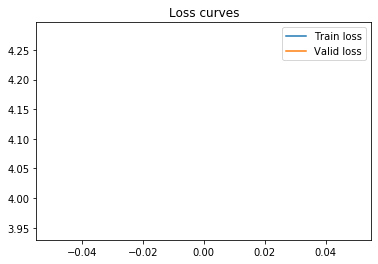

In [30]:
import matplotlib.pyplot as plt
import numpy

plot_cache = model_pt['plot_cache']

epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [i[0] for i in plot_cache], label='Train loss')
plt.plot(epochs, [i[1] for i in plot_cache], label='Valid loss')

plt.legend()
plt.title('Loss curves')
plt.show()

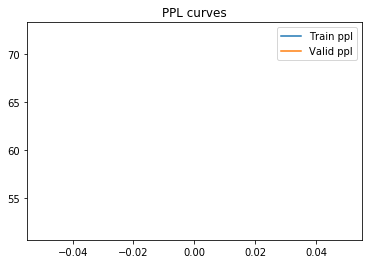

In [31]:
import matplotlib.pyplot as plt
import numpy

epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [2**(i[0]/numpy.log(2)) for i in plot_cache], label='Train ppl')
plt.plot(epochs, [2**(i[1]/numpy.log(2)) for i in plot_cache], label='Valid ppl')

plt.legend()
plt.title('PPL curves')
plt.show()

# Part 2 Decoding

## 2.2 N-Gram blocking

In [0]:
model_name = './chat_model_best_22.pt'

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

if current_device == 'cuda':
    model_pt = torch.load(model_name)
else:
    model_pt = torch.load(model_name, map_location=torch.device('cpu'))
opts = model_pt['opts']

model = seq2seq(opts)
model.load_state_dict(model_pt['state_dict'])
model.to(current_device)

plot_cache = model_pt['plot_cache']

In [0]:
import math
from operator import attrgetter


class Beam(object):
    """
    This class serves to keep info about partial hypothesis and perform the beam step
    """
    
    def __init__(
        self,
        beam_size,
        padding_token=0,
        bos_token=1,
        eos_token=2,
        min_length=3,
        min_n_best=3,
        device='cpu',
        # for iterbeam below
        similarity_metric='hamming',
        similarity_threshold=0,
        N = 3
    ):
        
        self.beam_size = beam_size
        self.min_length = min_length
        self.eos = eos_token
        self.bos = bos_token
        self.pad = padding_token
        self.device = device
        # recent score for each hypo in the beam
        self.scores = None
        # self.scores values per each time step
        self.all_scores = [torch.Tensor([0.0] * beam_size).to(self.device)]
        # backtracking id to hypothesis at previous time step
        self.bookkeep = []
        # output tokens at each time step
        self.outputs = [
            torch.Tensor(self.beam_size).long().fill_(self.bos).to(self.device)
        ]
        # keeps tuples (score, time_step, hyp_id)
        self.finished = []
        self.eos_top = False
        self.eos_top_ts = None
        self.n_best_counter = 0
        self.min_n_best = min_n_best
        self.partial_hyps = [[self.bos] for i in range(beam_size)]

        # iterbeam related below
        self.history_hyps = []
        self.similarity_metric = similarity_metric
        self.similarity_threshold = similarity_threshold
        self.banned_tokens = set()
        
        ### N-gram blocking
        self.N = N
      
    def get_output_from_current_step(self):
        """Get the output at the current step."""
        return self.outputs[-1]

    def get_backtrack_from_current_step(self):
        """Get the backtrack at the current step."""
        return self.bookkeep[-1]
    
    ##################### ITER-BEAM BLOCKING PART START #####################
    
    def hamming_distance(self, t1, t2):
        dist = 0
        for tok1, tok2 in zip(t1,t2):
            if tok1 != tok2:
                dist += 1
        return dist
    
    def edit_distance(self, t1, t2):
        import editdistance
        dist = editdistance.eval(t1, t2)
        return dist
                
    def similarity_check(self, active_hyp, previous_hyps, metric='hamming', threshold=0):
        #print('active_hyp', active_hyp)
        banned_tokens = []
        active_len = len(active_hyp)
        for observed_hyp, _banned_tokens in previous_hyps.items():
            if len(observed_hyp) != active_len:
                continue
            if metric == 'hamming':
                dist = self.hamming_distance(observed_hyp, active_hyp)
            if metric == 'edit':
                dist = self.edit_distance(observed_hyp, active_hyp)
            if dist <= threshold:
                banned_tokens.extend(_banned_tokens)
                    
        return list(set(banned_tokens))

    #######################################################
    ########## Add ngram blocking function here ###########
    #######################################################
    
    def get_ngram_blocking(self, text_vec, N = 3):
        # print('Start n-gram blocking for ', text_vec)
        banned = []
        
        if N == 1:  # special case: unigram
          banned = [i for i in text_vec[:-1] if i == text_vec[-1]]
        else:
          history = tuple(text_vec[-N+1:])
          for ngram in zip(*[text_vec[i:] for i in range(N)]):
              if ngram[:-1] == history:
                  banned.append(ngram[-1])
    
        return list(set(banned)) 
    
    ##################### ITER-BEAM BLOCKING PART END ########################
    
    def select_paths(self, logprobs, prior_scores, previous_hyps):
        """Select the next vocabulary item in these beams."""
        # beam search actually looks over all hypotheses together so we flatten
        beam_scores = logprobs + prior_scores.unsqueeze(1).expand_as(logprobs)
        # print('shape of beam score', beam_scores.size())
        # iterbeam blocking part
        current_length = len(self.all_scores)
        # print('all scores length', len(self.all_scores))
        if len(previous_hyps) > 0 and current_length > 0:
            for hyp_id in range(beam_scores.size(0)):
                active_hyp = tuple(self.partial_hyps[hyp_id])
                banned_tokens = self.similarity_check(active_hyp, previous_hyps, metric=self.similarity_metric, threshold=self.similarity_threshold)
                if len(banned_tokens) > 0:
                    beam_scores[:, banned_tokens] = -10e5
      
        ############################################################ 
        ################# Insert n-gram blocking here ##############
        ############################################################

        for hyp_id in range(beam_scores.size(0)):
            active_hyp = self.partial_hyps[hyp_id]
            # print('hyp_id: ', hyp_id)
            # print('active hyp ids: ', active_hyp)
            # print('active hyp tokens: ',chat_dict.v2t(active_hyp))

            if len(active_hyp) >= self.N + 1:
              banned_tokens = self.get_ngram_blocking(active_hyp, self.N)
              if len(banned_tokens) > 0:
              #  print(f'banned ids are:  {banned_tokens}, tokens: {chat_dict.v2t(banned_tokens)}')
                beam_scores[hyp_id, banned_tokens] = -10e5

        flat_beam_scores = beam_scores.view(-1)
       
        best_scores, best_idxs = torch.topk(flat_beam_scores, self.beam_size, dim=-1)

        # change the best_scores here 
        voc_size = logprobs.size(-1)

        # get the backtracking hypothesis id as a multiple of full voc_sizes
        hyp_ids = best_idxs / voc_size
        # get the actual word id from residual of the same division
        tok_ids = best_idxs % voc_size
        # print('tok_ids', chat_dict.v2t(tok_ids.cpu().tolist()))
        return (hyp_ids, tok_ids, best_scores)
    
    def advance(self, logprobs, previous_hyps):
        """Advance the beam one step."""
        current_length = len(self.all_scores) - 1
        if current_length < self.min_length:
            # penalize all eos probs to make it decode longer
            for hyp_id in range(logprobs.size(0)):
                logprobs[hyp_id][self.eos] = -10e5

        if self.scores is None:
            logprobs = logprobs[0:1]  # we use only the first hyp now, since they are all same
            self.scores = torch.zeros(1).type_as(logprobs).to(logprobs.device)
            
        hyp_ids, tok_ids, self.scores = self.select_paths(logprobs, self.scores, previous_hyps)

        # clone scores here to avoid referencing penalized EOS in the future!
        self.all_scores.append(self.scores.clone())
        # print('self.all_scores', self.all_scores)
        self.outputs.append(tok_ids)
        self.bookkeep.append(hyp_ids)
        self.partial_hyps = [
            self.partial_hyps[hyp_ids[i]] + [tok_ids[i].item()]
            for i in range(self.beam_size)
        ]
        self.history_hyps.extend(self.partial_hyps)
        
    
        # print('history hyps ids: ', self.history_hyps)
        # print('parital hyps at this step: ', self.partial_hyps)
        # print('log prob size',logprobs.size(0), logprobs.size(1))
        
        #print('history hyps tokens: ', chat_dict.v2t(self.history_hyps.cpu().tolist()))

        #  check new hypos for eos label, if we have some, add to finished
        for hypid in range(self.beam_size):
            if self.outputs[-1][hypid] == self.eos:
                self.scores[hypid] = -10e5
                #  this is finished hypo, adding to finished
                eostail = _HypothesisTail(
                    timestep=len(self.outputs) - 1,
                    hypid=hypid,
                    score=self.all_scores[-1][hypid],
                    tokenid=self.eos,
                )
                self.finished.append(eostail)
                self.n_best_counter += 1

        if self.outputs[-1][0] == self.eos:
            self.eos_top = True
            if self.eos_top_ts is None:
                self.eos_top_ts = len(self.outputs) - 1
    
    def is_done(self):
        """Return whether beam search is complete."""
        return self.eos_top and self.n_best_counter >= self.min_n_best

    def get_top_hyp(self):
        """
        Get single best hypothesis.
        :return: hypothesis sequence and the final score
        """
        return self._get_rescored_finished(n_best=1)[0]

    def _get_hyp_from_finished(self, hypothesis_tail):
        """
        Extract hypothesis ending with EOS at timestep with hyp_id.
        :param timestep:
            timestep with range up to len(self.outputs) - 1
        :param hyp_id:
            id with range up to beam_size - 1
        :return:
            hypothesis sequence
        """
        hyp_idx = []
        endback = hypothesis_tail.hypid
        for i in range(hypothesis_tail.timestep, -1, -1):
            hyp_idx.append(
                _HypothesisTail(
                    timestep=i,
                    hypid=endback,
                    score=self.all_scores[i][endback],
                    tokenid=self.outputs[i][endback],
                )
            )
            endback = self.bookkeep[i - 1][endback]

        return hyp_idx

    def _get_pretty_hypothesis(self, list_of_hypotails):
        """Return hypothesis as a tensor of token ids."""
        return torch.stack([ht.tokenid for ht in reversed(list_of_hypotails)])

    def _get_rescored_finished(self, n_best=None, add_length_penalty=False):
        """
        Return finished hypotheses according to adjusted scores.
        Score adjustment is done according to the Google NMT paper, which
        penalizes long utterances.
        :param n_best:
            number of finalized hypotheses to return
        :return:
            list of (tokens, score) pairs, in sorted order, where:
              - tokens is a tensor of token ids
              - score is the adjusted log probability of the entire utterance
        """
        # if we never actually finished, force one
        if not self.finished:
            self.finished.append(
                _HypothesisTail(
                    timestep=len(self.outputs) - 1,
                    hypid=0,
                    score=self.all_scores[-1][0],
                    tokenid=self.eos,
                )
            )

        rescored_finished = []
        for finished_item in self.finished:
            if add_length_penalty:
                current_length = finished_item.timestep + 1
                # these weights are from Google NMT paper
                length_penalty = math.pow((1 + current_length) / 6, 0.65)
            else:
                length_penalty = 1
            rescored_finished.append(
                _HypothesisTail(
                    timestep=finished_item.timestep,
                    hypid=finished_item.hypid,
                    score=finished_item.score / length_penalty,
                    tokenid=finished_item.tokenid,
                )
            )

        # Note: beam size is almost always pretty small, so sorting is cheap enough
        srted = sorted(rescored_finished, key=attrgetter('score'), reverse=True)

        if n_best is not None:
            srted = srted[:n_best]

        return [
            (self._get_pretty_hypothesis(self._get_hyp_from_finished(hyp)), hyp.score)
            for hyp in srted
        ]

## You present here:

In [0]:
# check pdf to see what you expected to present


In [0]:
def generate_with_beam(beam_size, min_n_best, model, batch, batch_size, previous_hyps=None, similarity_metric='hamming', similarity_threshold=0, verbose=False, N = 1):
    """
    This function takes a model, batch, beam settings and performs decoding with a beam
    """
    beams = [Beam(beam_size, min_n_best=min_n_best, eos_token=chat_dict.word2ind['__end__'], 
                  padding_token=chat_dict.word2ind['__null__'], 
                  bos_token=chat_dict.word2ind['__start__'], 
                  device=current_device, similarity_metric=similarity_metric, 
                  similarity_threshold=similarity_threshold, N = N) for _ in range(batch_size)]
    
    repeated_inds = torch.arange(batch_size).to(current_device).unsqueeze(1).repeat(1, beam_size).view(-1)

    text_vecs = batch['text_vecs'].to(current_device)

    encoder_states = model.encoder(text_vecs, batch['text_lens'], use_packed=batch['use_packed'])
    
    model.eval()
    
    encoder_states = reorder_encoder_states(encoder_states, repeated_inds)  # no actual reordering here, but repeating beam size times each sample in the minibatch
    encoder_output, encoder_hidden, attention_mask = encoder_states
    
    incr_state = encoder_hidden  # we init decoder hidden with last encoder_hidden
    
    # 1 is a start token id
    starts = torch.Tensor([1]).long().to(model.decoder.embedding.weight.device).expand(batch_size*beam_size, 1).long()  # expand to batch_size * beam_size
    decoder_input = starts
    
    with torch.no_grad():
        for ts in range(100):
            if all((b.is_done() for b in beams)):
                break
            score, incr_state, attn_w_log = model.decoder(decoder_input, incr_state, encoder_states)
            score = score[:, -1:, :]  # take last time step and eliminate the dimension
            score = score.view(batch_size, beam_size, -1)
            score = torch.log_softmax(score, dim=-1)
         
            for i, b in enumerate(beams):
                if not b.is_done():
                    # make mock previous_hyps if not used #
                    if previous_hyps is None:
                        previous_hyps = [{} for i in range(batch_size)]
                    b.advance(score[i], previous_hyps[i])
    
            incr_state_inds = torch.cat([beam_size * i + b.get_backtrack_from_current_step() for i, b in enumerate(beams)])
            incr_state = reorder_decoder_incremental_state(incr_state, incr_state_inds)
            selection = torch.cat([b.get_output_from_current_step() for b in beams]).unsqueeze(-1)
            #print('size of previous hyps', [b.get_output_from_current_step() for b in beams])
            decoder_input = selection

    beam_preds_scores = [list(b.get_top_hyp()) for b in beams]

    if verbose:
        for bi in range(batch_size):
            print(f'batch {bi}')
            for i in get_nbest_list_from_beam(beams[bi], chat_dict, n_best=min_n_best):
                print(i)
    
    return beam_preds_scores, beams

In [48]:
batch_size = 1
beam_size = 20
beam_n_best = 10

valid_loader_single = DataLoader(valid_dataset, shuffle=False, collate_fn=batchify, batch_size=batch_size)

valid_sample = next(iter(valid_loader_single))

print('Single example from validation set')
print('Validation text: ', chat_dict.v2t(valid_sample['text_vecs'][0].cpu().tolist()))
print('Validation target: ', chat_dict.v2t(valid_sample['target_vecs'][0].cpu().tolist()))


print('ngram = 1')
beam_preds_scores, beams = generate_with_beam(beam_size, beam_n_best, model, valid_sample, batch_size=batch_size, verbose=True, N = 1)

print('ngram = 2')
beam_preds_scores, beams = generate_with_beam(beam_size, beam_n_best, model, valid_sample, batch_size=batch_size, verbose=True, N = 2)

print('ngram = 3')
beam_preds_scores, beams = generate_with_beam(beam_size, beam_n_best, model, valid_sample, batch_size=batch_size, verbose=True, N = 3)


Single example from validation set
Validation text:  your persona : i read twenty books a year . 
 your persona : i ' m a stunt double as my second job . 
 your persona : i only eat __unk__ . 
 your persona : i was raised in a single parent household . 
 hello what are doing today ?
Validation target:  i am good , i just got off work and tired , i have two jobs . __end__
ngram = 1
batch 0
('__start__ i am good how are you __end__', -5.82402229309082)
("__start__ i ' m good how are you __end__", -6.111946105957031)
('__start__ hi how are you today __end__', -6.116390228271484)
('__start__ i am good how are you ? __end__', -6.397331237792969)
('__start__ hi how are you doing __end__', -6.450916290283203)
("__start__ i ' m good how are you ? __end__", -6.650628089904785)
("__start__ i ' m good . how are you ? __end__", -7.28643798828125)
("__start__ i ' m doing well , how are you ? __end__", -7.779935836791992)
("__start__ i ' m doing great . how are you ? __end__", -7.984478950500488)
("